## The linear regression problem - JAX+numpyro

In [1]:
from IPython.display import set_matplotlib_formats
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
from jax import random, vmap
import jax.numpy as jnp
import seaborn as sns
import pandas as pd
import numpy as np
import os

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SA
from numpyro import handlers

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

#assert numpyro.__version__.startswith('0.6.0')
#numpyro.set_platform("gpu")

numpyro.set_platform("cpu")
numpyro.set_host_device_count(5)

In [2]:
import emcee

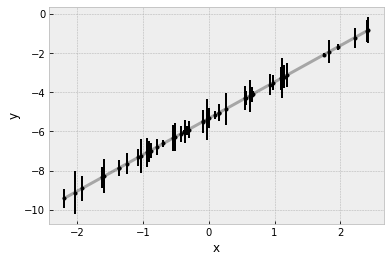

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = 1.8594
b_true = -5.3294

# Generate some synthetic data from the model.
N = 50
m_sigma = 0.5
x = np.sort(5 * (np.random.rand(N)-0.5))
y = m_true * x + b_true
y = m_true*x + b_true
yerr = np.random.randn(N)*m_sigma

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(x.min(), x.max(), 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlabel("x")
plt.ylabel("y");


In [4]:
def linear_func(m=None, x=x, b=None):
    return m*x + b

def model(x):
    b = numpyro.sample('b', dist.Uniform(-2.*abs(b_true), 2.*abs(b_true)))
    m = numpyro.sample('m', dist.Uniform(-2.*abs(m_true), 2.*abs(m_true)))
    
    #sigma = numpyro.sample('sigma', dist.Uniform(0.1, 10.0))
    ym = numpyro.deterministic('ym', linear_func(m=m, x=x, b=b))
    numpyro.factor('obs', dist.Normal(ym, m_sigma).log_prob(y))
    #return numpyro.sample('obs', dist.Normal(mu, m_sigma), obs=y)
    
#standardize = lambda x: (x - x.mean()) / x.std()
#x_scaled = standardize(x)
#y_scaled = standardize(y)#

#plt.plot(x_scaled, y_scaled, '.')
#plt.plot(x, y, 'x')

In [13]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(12)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
#kernel = SA(model)
mcmc = MCMC(kernel, num_warmup=20, num_samples=150)#, num_chains=5)


In [14]:
mcmc.run(rng_key_, x=x, extra_fields=('potential_energy',))
#mcmc.run(rng_key_, x_scaled=x_scaled)
mcmc.print_summary()
samples_1 = mcmc.get_samples()
print(f"b_true = {b_true}")
print(f"m_true = {m_true}")

sample: 100%|██████████| 170/170 [00:02<00:00, 61.06it/s, 3 steps of size 9.13e-02. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b     -5.34      0.06     -5.34     -5.43     -5.26     61.33      0.99
         m      1.86      0.05      1.86      1.79      1.97     89.46      0.99

Number of divergences: 0
b_true = -5.3294
m_true = 1.8594


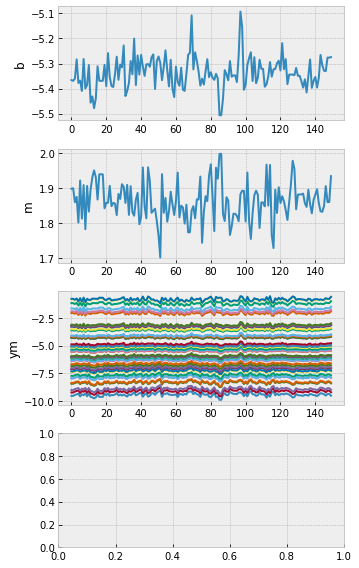

In [15]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5, 8))
axs = axs.flatten()
count = 0
for key in samples_1.keys():
    axs[count].plot(samples_1[f'{key}'])
    axs[count].set_ylabel(f'{key}')
    count += 1
plt.tight_layout()
#plt.plot(samples_1['m'])

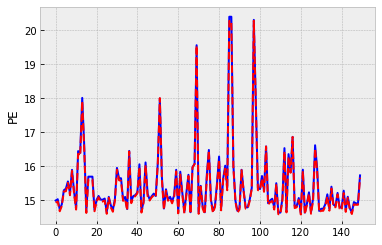

sigma(y) = 0.0890, y_sigma = 0.08577854931354523


In [33]:
NAX = np.newaxis
pe = mcmc.get_extra_fields()['potential_energy']
y_all = samples_1['ym']
var = (y_all - y[NAX, :])/m_sigma
sig = var**2
sigma = (sig + np.log(2*np.pi*m_sigma**2)).sum(axis=1)

plt.figure()
plt.plot(pe, 'b')
plt.plot(sigma/2 +3.3, '--r')
plt.ylabel('PE')
plt.show()

y_all = samples_1['m'][:, NAX]*x[NAX, :] + samples_1['b'][:, NAX]
m_sig = np.std(samples_1['m'])
b_sig = np.std(samples_1['b'])
ymean = y_all.mean(axis=0)
y_sig = np.sqrt( x*x*m_sig*m_sig + b_sig*b_sig)
print(f"sigma(y) = {np.std(samples_1['ym'] - ymean):.4f}, y_sigma = {np.mean(y_sig)}")

In [ ]:
np.std(np.random.randn(1000)*m_sigma)

In [ ]:
def plot_regression(x, y_mean, y_hpdi, percentile_val):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(x, y_mean, '--k', linewidth=0.5, label='mean inferred (JAX)')
    ax.plot(x0, f_true * (m_true * x0 + b_true), "r", alpha=0.3, lw=3, label='true')
    #ax.plot(x, y, 'o')
    ax.errorbar(x, y, yerr=yerr, fmt='or', label='data')
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.8, interpolate=True, label=f'{percentile_val} percentile')
    ax.legend()
    return ax

# Compute empirical posterior distribution over mu
posterior_mu = (jnp.expand_dims(samples_1['m'], -1) * x + 
                jnp.expand_dims(samples_1['b'], -1))
mean_mu = jnp.mean(posterior_mu, axis=0)
percentile_val = 0.64
hpdi_mu = hpdi(posterior_mu, percentile_val)

#plt.plot(x, y, 'x')
#plt.plot(x, mean_mu)
plot_regression(x, mean_mu, hpdi_mu, percentile_val*100)

In [ ]:
numpyro.set_platform('gpu')

In [ ]:
mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(y, mean_mu, hpdi_mu, percentile_val=60)

In [ ]:
?numpyro.plate

In [ ]:
?dist.Uniform

In [ ]:
?dist.Normal